# Using cholesky to create correlated weights

 \begin{align*}
 G_0 & = \sum_{k=1}^\infty \beta_k \delta_{\phi_k} \\
 G_j &= \sum_{k=1}^\infty \pi_{jk} \delta_{\phi_k} \\
 \phi_k & \sim \text{Dirichlet} \\

 \end{align*}

 The model above is the original HDP model. What we would then like to do is to incorporate the correlation of the weights to say that 

\begin{equation}
\text{cov} ( \log \pi_i, \log \pi_j) = \exp(-\xi||s_i - s_j||) = (H_J(\xi))_{ij} 
\end{equation}

where $s_i$ is the location of cell $i$ and $\pi_i$ is the weights for cell $i$ over the different topics. In general we would like 
\begin{equation}
\log \Pi \sim N_n(\mu_n, H_J(\xi))
\end{equation}
We would like to impose this by multiplying the cholesky of the covariance matrix:
\begin{equation}
 \Pi = \exp\left(\log \Pi \sqrt{H_J(\xi)} \right)
\end{equation}

This was a bit problematic to do this directly as for each observation they are iterating through the updates:  
\begin{align*}
\varphi_{jtk} &\propto \exp\left( \sum_n \zeta_{jnt} \mathbb{E}_q [\log p(w_{jn})|\phi_k] + \mathbb{E}_q[log \beta_k]\right) \\
\zeta_{jnt} &\propto \exp \left( \sum_k \varphi_{jtk} \mathbb{E}_q[\log p(w_{jn}|\phi_k)] + \mathbb{E}_q[\log \pi_{jt}]\right)
\end{align*}
For each document/cell you will have 

\begin{align*}
\varphi_j &= \begin{pmatrix} &&\\
&\text{ T(second level topics) x K(top level topics)}& \\
& & 
\end{pmatrix} \\
\zeta_j &= \begin{pmatrix}
& & \\
& \text{N(words / genes ) x T(second level topics)}& \\
&& 
\end{pmatrix} \\

\zeta_j \varphi_j &= \begin{pmatrix}
& & \\
&\text{N(words / genes) x K(top level topics)}& \\
& & 
\end{pmatrix}
\end{align*}



What I did:
- Make a warm start from the results of an original hdp model
- Iterating between $\varphi_j$ and $\zeta_j$ until convergence for observations(as before) within a certain chunk. 
- Then make the matrices $\zeta_j \varphi_j$ correlate within that chunk, before assigning them to update. 




Questions: 
- Why can I not get it to work, when I say that the probalities between the second level topics and top level topics are the same? 
- What should the lengthscale be?
- How should we define the chunks? size and position
- How do we evaluate how well we are doing?


In [1]:
import scanpy as sc
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# import data
adata_sub=sc.read_h5ad("data/LH_VMSC02001_sub.h5ad")

with open('data/LH_VMSC02001_sub_dictionary.pkl', 'rb') as ff:
    dictionary = pickle.load(ff)

with open('data/LH_VMSC02001_sub_BoW_corpus.pkl', 'rb') as f2:
    BoW_corpus = pickle.load(f2)

spatial=adata_sub.obsm['spatial']
spatial[:,1] = -spatial[:,1]

In [9]:
adata_sub.X

array([[0., 1., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [3]:
# save data as csv file to open in R
df = pd.DataFrame(spatial)
#df.to_csv('LH_location.csv')


In [4]:
df = pd.DataFrame(adata_sub.X)
df.columns = adata_sub.var_names
df.to_csv('LH_counts.csv')


In [2]:
anno=sc.read_h5ad("/gladstone/engelhardt/pelka-collaboration/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/vizgen_public_midlevel_annotated.h5ad")



In [3]:
anno

AnnData object with n_obs × n_vars = 754866 × 500
    obs: 'cell', 'n_genes_by_counts', 'total_counts', 'n_counts', 'cell_type', 'kmeans11_anno', 'kmeans11', 'midlevel_type'
    var: 'gene', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'kmeans11_colors', 'kmeans12_colors', 'kmeans13_colors', 'kmeans14_colors', 'kmeans15_colors', 'kmeans16_colors', 'kmeans17_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/home/rlaursen/miniconda3/envs/def/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/rlaursen/miniconda3/envs/def/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/rlaursen/miniconda3/envs/def/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


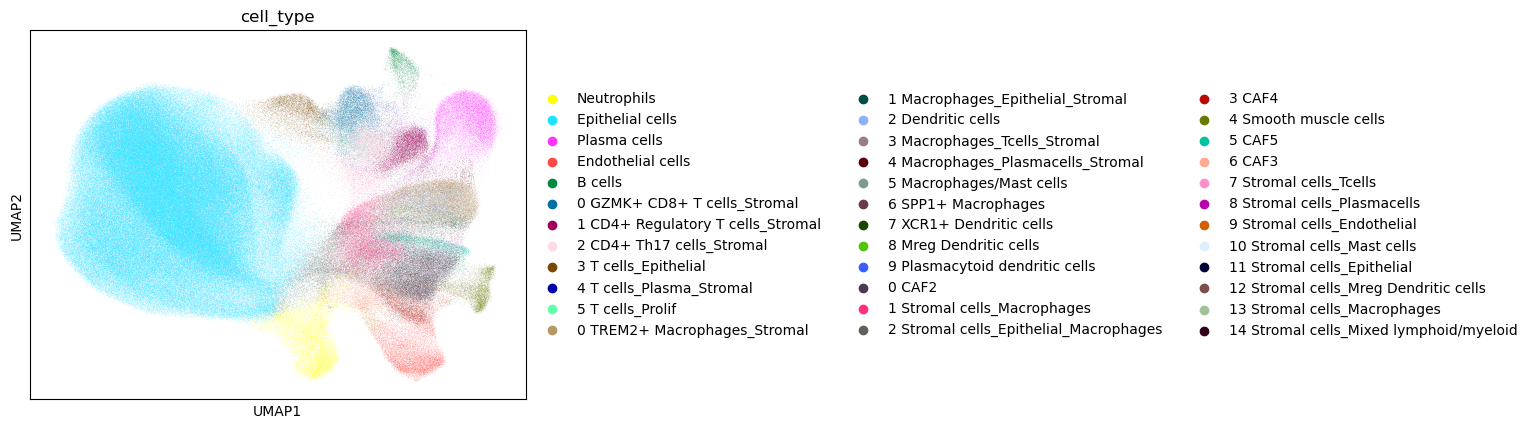

In [6]:
sc.pl.umap(anno, color = 'cell_type')

In [7]:
anno

AnnData object with n_obs × n_vars = 754866 × 500
    obs: 'cell', 'n_genes_by_counts', 'total_counts', 'n_counts', 'cell_type', 'kmeans11_anno', 'kmeans11', 'midlevel_type'
    var: 'gene', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'kmeans11_colors', 'kmeans12_colors', 'kmeans13_colors', 'kmeans14_colors', 'kmeans15_colors', 'kmeans16_colors', 'kmeans17_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [14]:
df = pd.DataFrame(anno.obs["midlevel_type"])
df.to_csv('data/midlevel_type.csv')

## Running the original hdp model

In [5]:
from gensim.models.hdpmodel import HdpModel
T=150
K =150
hdp0 = HdpModel(BoW_corpus, dictionary, T = T, K = K,random_state=1, var_converge=1e-6)
#with open('LHsample_base.pkl', 'wb') as file:
#    pickle.dump(hdp0, file)

In [6]:
# recovering the weights for the different topics
result_dist0=hdp0[BoW_corpus]

# save the HDP clusters to the object
prop0 = np.empty((len(BoW_corpus),T), float)#pd.DataFrame([])
for ii in range(len(BoW_corpus)):
    #dic={}
    rr=np.zeros(T)
    result=np.array(result_dist0[ii])
    rr[result[:,0].astype(int)]=result[:,1]
    rr=np.reshape(rr,(1,T)) 
    prop0[ii,:]=rr

# taking out topics with positive probability
#pos = prop0[:,np.where(np.sum(prop0, axis = 0) > 0)].squeeze()
pos = prop0

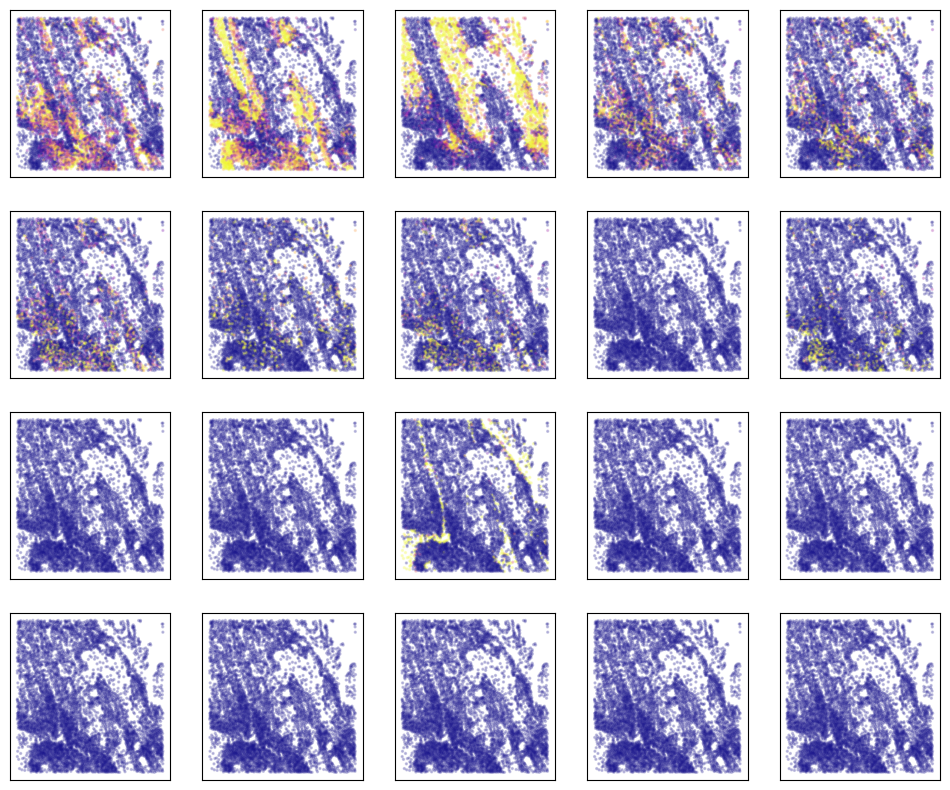

In [5]:
max_val = np.percentile(pos, 95, 0)
min_val = np.percentile(pos, 1, 0)

plt.figure(figsize=(12, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = pos[:,i], cmap = 'plasma', alpha = 0.2, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])

# Incoorporating spatial information

In [10]:
def squared_dist(X, Z):
    
    X2 = (X**2).sum(1, keepdims=True)
    Z2 = (Z**2).sum(1, keepdims=True)
    XZ = X @ Z.T
    r = X2 - 2 * XZ + Z2.T
    r[r<0] = 0
    r2 = np.sqrt(r)
    return r2
# create distance matrix
cells = spatial.shape[0]
dist = squared_dist(spatial,spatial)

## Own hdp function

In [42]:
# The length scales here are defined from quantile of the distance matrix
print(np.percentile(dist,[0.1,0.5,1,2,3,4,5]))


[103.69924675 244.92272116 354.79701877 515.44495794 641.93683734
 750.34005204 847.67476365]


In [51]:
# checking how many cells are included
cov = np.exp(-(3/750)*dist)
sum(cov[0] > 1e-3)

675

### Grouping the chunks

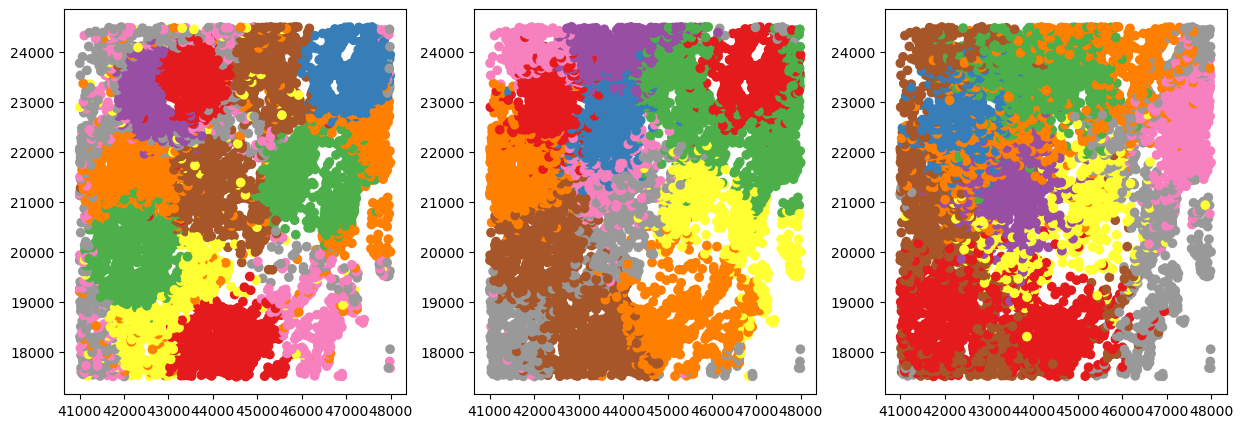

In [8]:
from GaussianPrior.hdpmodelchunk import groupondist
plt.figure(figsize=(15, 5))

idx = groupondist(dist = dist, percentile = 0.5, chunksize = 500)

col = np.zeros(dist.shape[0])
for ii in range(len(idx)):
    col[idx[ii]] = ii

plt.subplot(1, 3, 1)
plt.scatter(x=spatial[:,0], y=spatial[:,1], c = col, cmap = 'Set1')

phi = 3/np.percentile(dist,1)
cov = np.exp(-phi*dist)

idx = groupondist(dist = dist, percentile = 2, chunksize = 500)

col = np.zeros(dist.shape[0])
for ii in range(len(idx)):
    col[idx[ii]] = ii
plt.subplot(1, 3, 2)
plt.scatter(x=spatial[:,0], y=spatial[:,1], c = col, cmap = 'Set1')

idx = groupondist(dist = dist, percentile = 5, chunksize = 500)

col = np.zeros(dist.shape[0])
for ii in range(len(idx)):
    col[idx[ii]] = ii
plt.subplot(1, 3, 3)
plt.scatter(x=spatial[:,0], y=spatial[:,1], c = col, cmap = 'Set1')

### Running the spatial model

In [13]:
from model.hdpmodelchunk import HdpModel_spatial
K = 150
length = np.percentile(dist,3)
hdp_s = HdpModel_spatial(BoW_corpus, dictionary, dist = dist, length = length,  passes = 1, T = T, K = K, random_state=2, chunksize= 500)

In [14]:
hdp_s.warm_start(lambda_val = hdp0.m_lambda, var_sticks=hdp0.m_var_sticks, varphi=hdp0.m_varphi_ss)

hdp_s.update(BoW_corpus)

3
2
3
2
3
2
3
2
3
2
3
3
2
2
finished


In [11]:
#with open('LHsample_spatial.pkl', 'wb') as file:
#    pickle.dump(hdp_s, file)

In [11]:
# recovering the weights for the different topics
result_dist0=hdp_s[BoW_corpus]

# save the HDP clusters to the object
prop_s = np.empty((len(BoW_corpus),T), float)#pd.DataFrame([])
for ii in range(len(BoW_corpus)):
    #dic={}
    rr=np.zeros(T)
    result=np.array(result_dist0[ii])
    rr[result[:,0].astype(int)]=result[:,1]
    rr=np.reshape(rr,(1,T)) 
    prop_s[ii,:]=rr

# taking out topics with positive probability
#pos_s = prop0[:,np.where(np.sum(prop0, axis = 0) > 0)].squeeze()


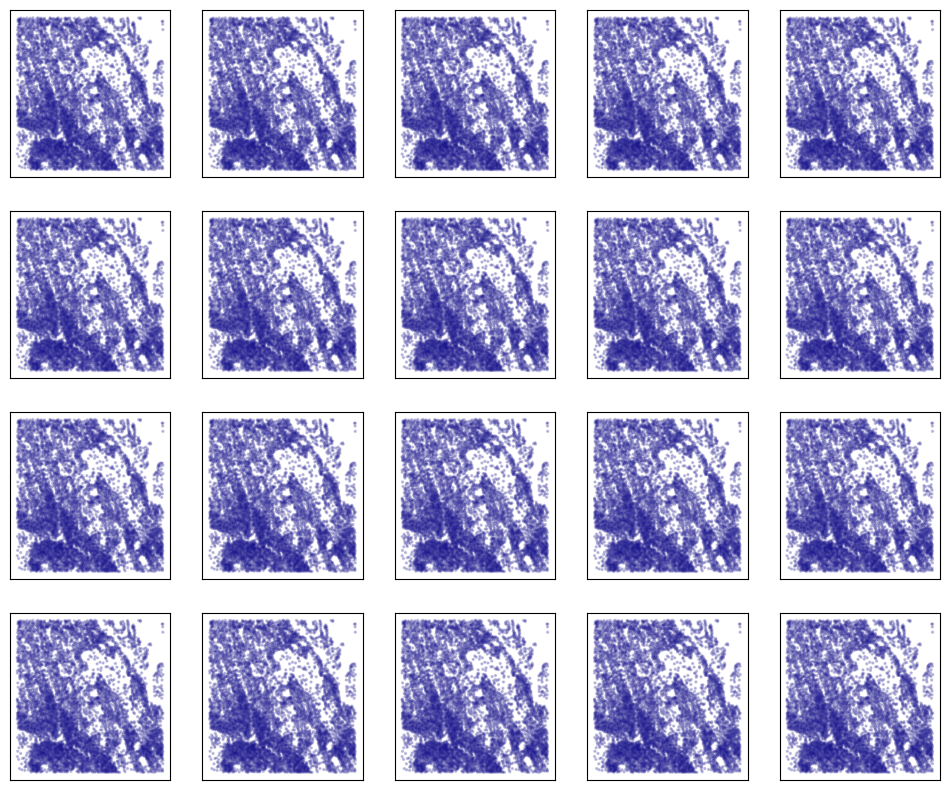

In [15]:
max_val = np.percentile(prop_s, 95, 0)
min_val = np.percentile(prop_s, 1, 0)

plt.figure(figsize=(12, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = prop_s[:,i], cmap = 'plasma', alpha = 0.2, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])

In [14]:
# Looking at topics

topics = hdp_s.print_topics(num_topics = 5, num_words = 10)

topics[0]


(0,
 '0.085*PKM + 0.050*SOX9 + 0.043*VEGFA + 0.041*CTNNB1 + 0.039*EPCAM + 0.027*AXIN2 + 0.026*HLA-B + 0.020*CDH1 + 0.019*MYC + 0.016*TGFBI')

## Weighting by cholesky

In [21]:
dist[0:5,0:5]

array([[   0.        ,  709.89581929,  526.39446726,  517.78198758,
         295.35554716],
       [ 709.89581929,    0.        , 1236.29016613,  192.33332735,
        1005.07364787],
       [ 526.39446726, 1236.29016613,    0.        , 1044.14991842,
         231.58707241],
       [ 517.78198758,  192.33332735, 1044.14991842,    0.        ,
         813.07332886],
       [ 295.35554716, 1005.07364787,  231.58707241,  813.07332886,
           0.        ]])

LinAlgError: Matrix is not positive definite

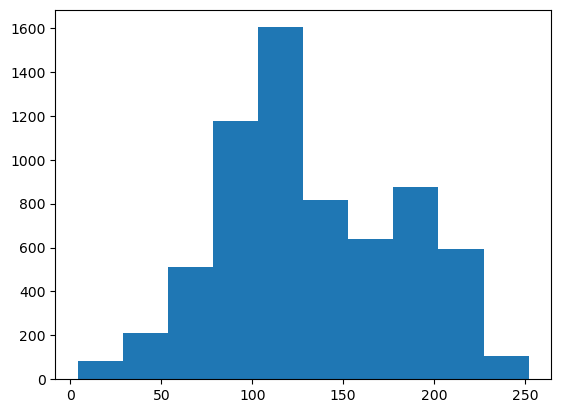

In [20]:
# add cholesky to weights 
# create covariance matrix
phi = 3/np.percentile(dist,2)
cov = np.exp(-phi*dist)
cov[cov < 0.05] = 0
plt.hist(np.sum(cov>0,0))

L = np.linalg.cholesky(cov)

mat_s_chol = 1e-5 * np.exp(L @ np.log(pos*1e+5 + 1e-50))
mat_s_chol2 = 1e-5 * np.exp(L @ np.log(mat_s_chol*1e+5))
mat_s_chol3 = 1e-5 * np.exp(L @ np.log(mat_s_chol2*1e+5))
mat_s_chol4 = 1e-5 * np.exp(L @ np.log(mat_s_chol3*1e+5))
max_val = np.percentile(pos, 95, 0)
min_val = np.percentile(pos, 1, 0)

plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = pos[:,i], cmap = 'plasma', alpha = 0.5, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5, 5, 5+i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = mat_s_chol[:,i], cmap = 'plasma', alpha = 0.5, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5, 5, 10+i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = mat_s_chol2[:,i], cmap = 'plasma', alpha = 0.5, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5, 5, 15+i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = mat_s_chol3[:,i], cmap = 'plasma', alpha = 0.5, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5, 5, 20+i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = mat_s_chol4[:,i], cmap = 'plasma', alpha = 0.5, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])


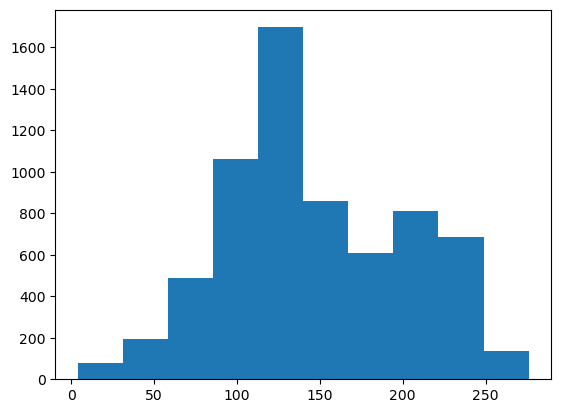

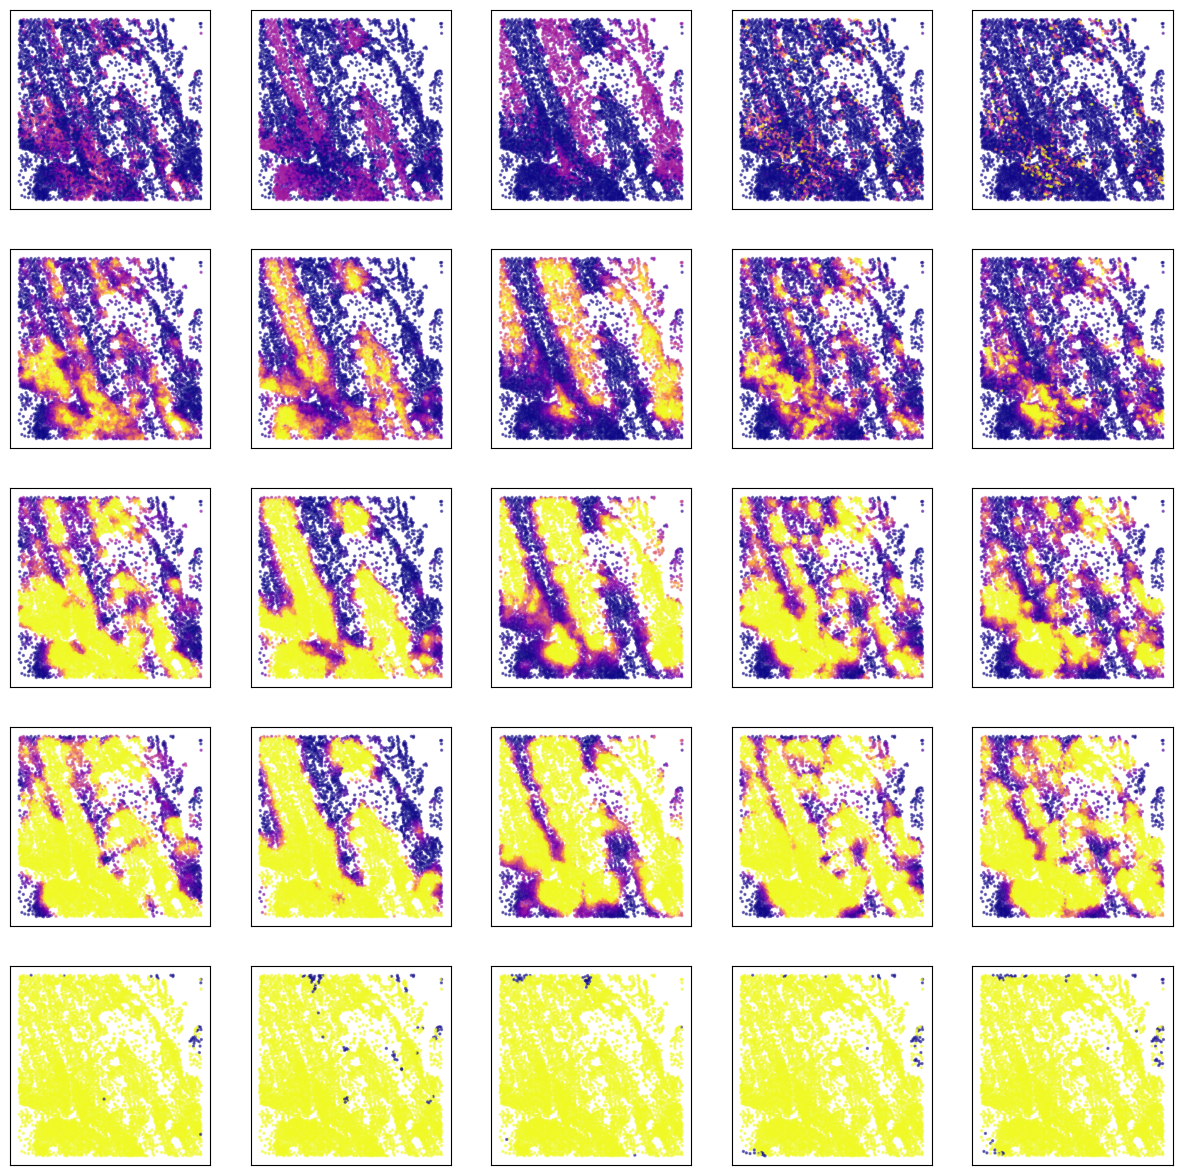

In [25]:
# add cholesky to weights 
# create covariance matrix
phi = 3/np.percentile(dist,1)
cov = np.exp(-phi*dist)
cov[cov < 0.01] = 0
plt.hist(np.sum(cov>0,0))

L = np.linalg.cholesky(cov)

mat_s_chol = L @ pos
mat_s_chol2 = L @ mat_s_chol
mat_s_chol3 = L @ mat_s_chol2
mat_s_chol4 = L @ mat_s_chol3*1e+15
max_val = np.percentile(mat_s_chol, 95, 0)
min_val = np.percentile(mat_s_chol, 1, 0)

plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = pos[:,i], cmap = 'plasma', alpha = 0.5, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5, 5, 5+i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = mat_s_chol[:,i], cmap = 'plasma', alpha = 0.5, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5, 5, 10+i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = mat_s_chol2[:,i], cmap = 'plasma', alpha = 0.5, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5, 5, 15+i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = mat_s_chol3[:,i], cmap = 'plasma', alpha = 0.5, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5, 5, 20+i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = mat_s_chol4[:,i], cmap = 'plasma', alpha = 0.5, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])

In [71]:
corrmat = np.corrcoef(pos)

print(corrmat[0:3,0:3])

print(cov[0:3,0:3])

[[ 1.          0.97522921  0.10434827]
 [ 0.97522921  1.         -0.01030883]
 [ 0.10434827 -0.01030883  1.        ]]
[[0.99997326 0.00247244 0.01166749]
 [0.00247244 0.99997326 0.        ]
 [0.01166749 0.         0.99997326]]


[1. 1. 1. ... 1. 1. 1.]


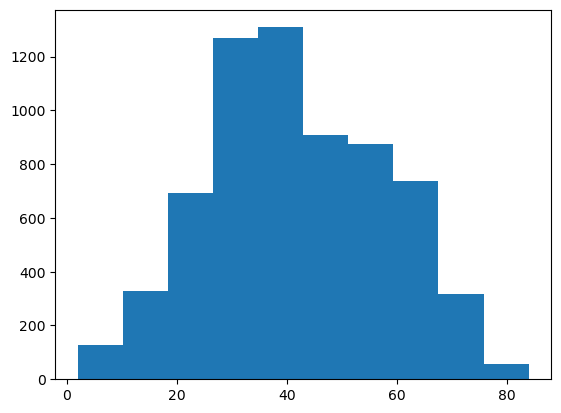

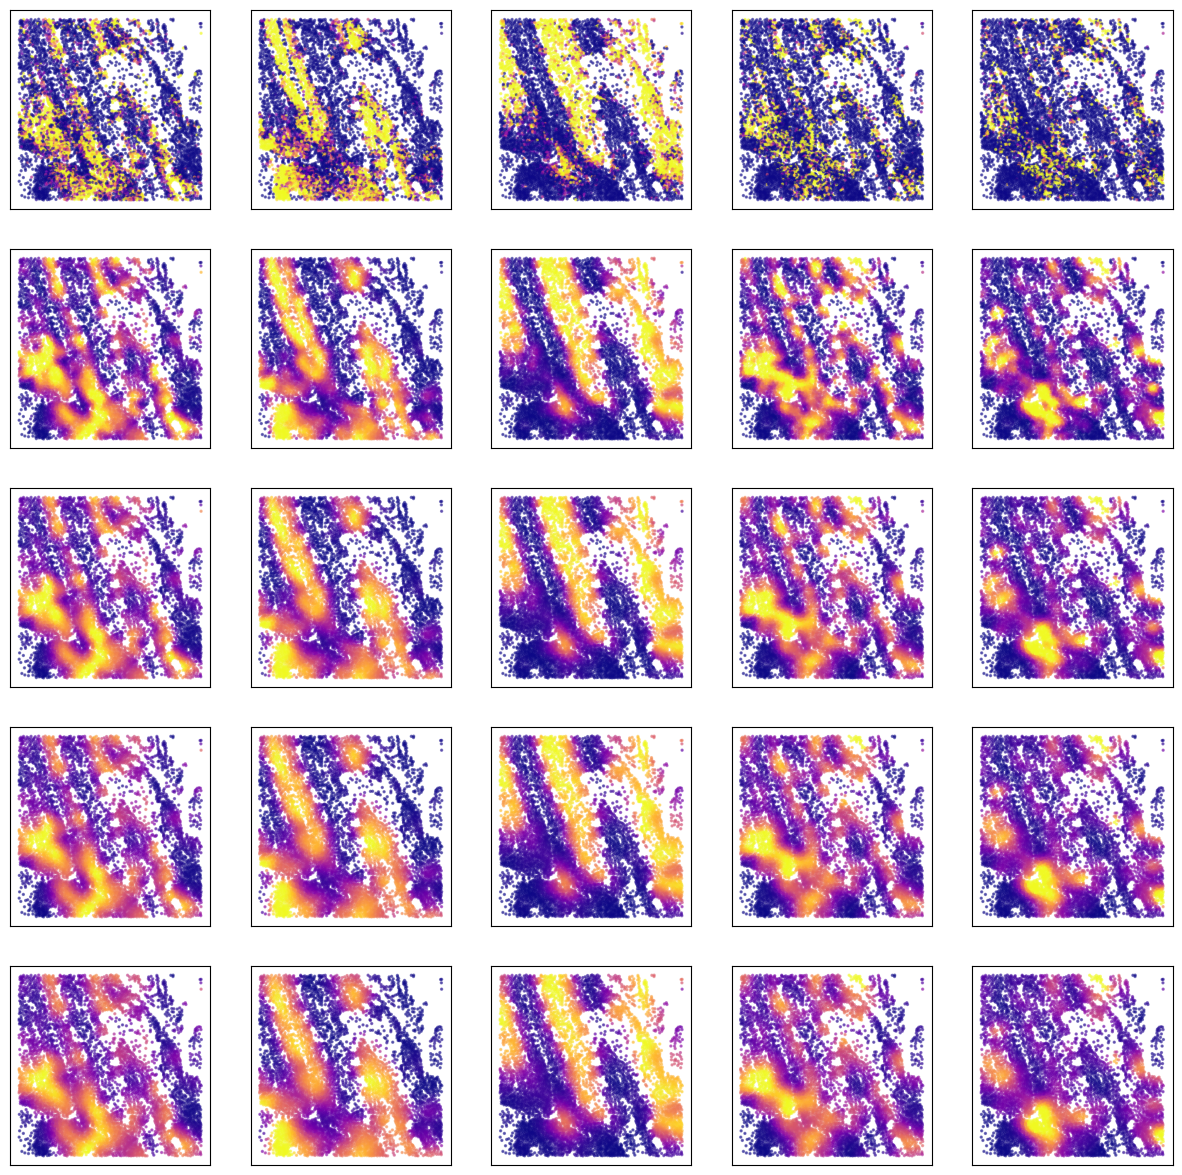

In [26]:
# Using weighting to smooth out the weights

# add cholesky to weights 
# create covariance matrix
phi = 3/np.percentile(dist,2)
cov = np.exp(-phi*dist)
cov[cov < 0.2] = 0
plt.hist(np.sum(cov>0,0))
cov_sum = cov.sum(axis = 1)

w = cov / cov_sum[:,np.newaxis]
print(w.sum(axis = 1))

mat_s_chol = w @ pos
mat_s_chol2 = w @ mat_s_chol
mat_s_chol3 = w @ mat_s_chol2
mat_s_chol4 = w @ mat_s_chol3
max_val = np.percentile(mat_s_chol, 95, 0)
min_val = np.percentile(mat_s_chol, 1, 0)

plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = pos[:,i], cmap = 'plasma', alpha = 0.5, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5, 5, 5+i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = mat_s_chol[:,i], cmap = 'plasma', alpha = 0.5, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5, 5, 10+i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = mat_s_chol2[:,i], cmap = 'plasma', alpha = 0.5, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5, 5, 15+i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = mat_s_chol3[:,i], cmap = 'plasma', alpha = 0.5, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5, 5, 20+i+1)
    plt.scatter(x=spatial[:,0], y=spatial[:,1], c = mat_s_chol4[:,i], cmap = 'plasma', alpha = 0.5, s = 2, vmin=min_val[i], vmax=max_val[i])
    plt.xticks([])
    plt.yticks([])
